In [1]:
import statsmodels, scipy.stats, numpy, pandas, seaborn, pylab
%matplotlib inline

This shows the difference between various beta-binomial distributions and a plain binomial distribution.  In Multipool 1.0, I was assuming that the marginal $p(x)$ was a binomial (with $\mu=\frac{1}{2}$), instead of accounting for uncertainty in the prior value of the causal locus allele frequency ($p$).  A better approach is to assume $p \sim \textrm{Beta}(a, b)$, so that $p(x) = \int p(x \mid p) p(p) dp = \textrm{BetaBinom}(n,a,b)$.  In effect, I was espousing a strong belief that $p$ was near $\frac{1}{2}$ (actually, that it was exactly $\frac{1}{2}$).  Subsequent sections will show the impact this has on the calculated LOD scores, compared to more diffuse priors on $p$ (including up to a uniform prior).

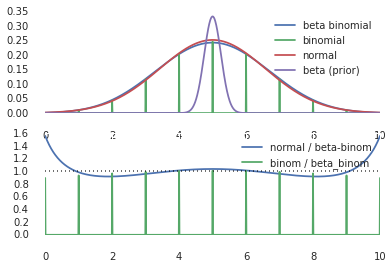

720.0 720.0


In [144]:
def beta_binom_pdf(k, n, a, b):
    g = scipy.special.gamma
    # return g(n+1.0) / (g(k+1.0) * g(n-k+1.0)) * g(k+a) * g(n-k+b) / g(n+a+b) * g(a+b) / g(a) / g(b)
    # do it in log-space to tolerate large values
    lg = scipy.special.gammaln
    return numpy.exp(lg(n+1.0) - lg(k+1.0) - lg(n-k+1.0) + lg(k+a) + lg(n-k+b) - lg(n+a+b) + lg(a+b) - lg(a) - lg(b))


x = numpy.arange(0, 10 + 1e-6, 0.01)
xi = numpy.arange(0, 10 + 1e-6, 1)
ab = 200
beta_binom = beta_binom_pdf(x, 10, ab, ab)
binom = scipy.stats.binom.pmf(x, 10, 0.5)
normal = scipy.stats.norm.pdf(x, 5, (0.5*0.5*10)**0.5)
beta = scipy.stats.beta.pdf(x / x.max(), ab, ab)
beta /= 3.0 * beta.max() # ??

pylab.subplot(211)
pylab.plot(x, beta_binom, label="beta binomial")
pylab.plot(x, binom, label="binomial")
pylab.plot(x, normal, label="normal")
pylab.plot(x, beta, label="beta (prior)")
seaborn.despine(offset=10)
pylab.legend()

pylab.subplot(212)
pylab.plot(x, normal / beta_binom, label="normal / beta-binom")
pylab.plot(x, binom / beta_binom, label="binom / beta_binom")
# pylab.plot(x, binom / normal, label="binom / normal")
pylab.axhline(1, ls=":", color="k", lw=1.5, alpha=0.75)
seaborn.despine(offset=10)
pylab.legend()

pylab.show()
print numpy.exp(scipy.special.gammaln(7)), scipy.special.gamma(7)

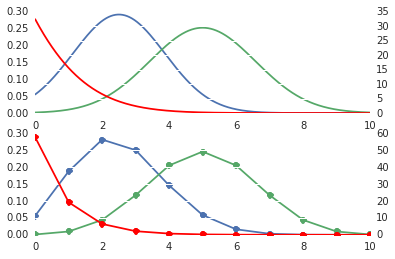

In [142]:
normal1 = scipy.stats.norm.pdf(x, 2.5, (0.25*0.75*10)**0.5)
normal2 = scipy.stats.norm.pdf(x, 5, (0.5*0.5*10)**0.5)

binom1 = scipy.stats.binom.pmf(xi, 10, 0.25)
binom2 = scipy.stats.binom.pmf(xi, 10, 0.5)

pylab.subplot(211)
pylab.plot(x, normal1)
pylab.plot(x, normal2)
pylab.twinx()
pylab.plot(x, normal1/normal2, 'r')

pylab.subplot(212)
pylab.plot(xi, binom1, 'o-')
pylab.plot(xi, binom2, 'o-')
pylab.twinx()
pylab.plot(xi, binom1/binom2, 'ro-')


pylab.show()


In [273]:
# from multipool 1
def lognormpdf(x, mu, sigma):
    return -0.5*numpy.log(2*numpy.pi) - numpy.log(sigma) + (-(x-mu)**2.0/2.0/sigma**2.0)

def calcLODs_multicoupled(mu_pstr_vec, V_pstr_vec, T, N):
    LOD = numpy.zeros(T)
    mu_MLE = numpy.zeros(T)

    # Initial parameters (null model for genomic region)
    mu_initial = 0.5*N
    V_initial = 0.25*N
    
    # We're trying to calculate LR(i) = max_p' Pr(y | p=p') / Pr (y | p=1/2)
    #     = max_p' int_0^1 Pr(x_i=j | y) / Pr(x_i=j) * Pr(x_i=j | p=p') dj
    # 
    # We compute it by discretizing the choices for p' and approximating
    # the values the integral takes on for each choice.

    # Grid for p':
    delta = 0.0001
    x = numpy.arange(delta, 1.0-delta+delta/2, delta)

    # Precompute values of Pr(x_i=j | p=p') (for each value of p'):
    p_precomp = numpy.array([scipy.stats.norm.pdf(N*x, N*p_alt, numpy.sqrt(p_alt*(1.0-p_alt)*N)) for p_alt in x])

    # This works because these quantities do not depend on the
    # observed data (y, through mu_pstr or V_pstr) and are shared
    # across all timepoints (indexed by i in the loop below).

    # log Pr(x_i=j) (unconditional model, from the stationary distribution)
    logreweighter_old = lognormpdf(N*x, mu_initial, numpy.sqrt(V_initial)) # original
    logreweighter = numpy.log(beta_binom_pdf(N*x, N, 10, 10)) # a,b ==> inf is what the original was
    
    pylab.plot(numpy.exp(logreweighter_old), numpy.exp(logreweighter))
    # seaborn.jointplot(numpy.exp(logreweighter_old), numpy.exp(logreweighter))
    pylab.xlabel("orig")
    pylab.ylabel("new")
    print "orig sum:", numpy.sum(numpy.exp(logreweighter_old))
    print "new sum:", numpy.sum(numpy.exp(logreweighter))
    pylab.show()

    for i in xrange(T):
        logallsums = numpy.zeros(len(x))
        for mu_pstr, V_pstr in zip(mu_pstr_vec, V_pstr_vec):
            # log( Pr(x_i=j | y)) - log( Pr(x_i=j))
            logtemp = lognormpdf(N*x, mu_pstr[i], numpy.sqrt(V_pstr[i])) - logreweighter
            scaler = logtemp.max() # We use this trick to keep the numbers in range: X = C * X / C, etc.
            logallsums += scaler + numpy.log(1e-300 + numpy.dot(p_precomp, numpy.exp(logtemp - scaler)))

        # Now, we calculate a bunch of integrals with grids by
        # multiplying by the rows of p_precomp.  Each row
        # corresponds to a value of p' that we want to optimize
        # over.  We pick the best p'.
        ### pylab.plot(x, logallsums)
        p_alt = x[logallsums.argmax()] * N
        mu_MLE[i] = p_alt

        # LOD[i] = numpy.log10(N*(x[1]-x[0]) * allsums.max())
        LOD[i] = numpy.log10(N) + numpy.log10(x[1]-x[0]) + logallsums.max() / numpy.log(10.0)
        
        nullLOD = numpy.log10(N) + numpy.log10(x[1]-x[0]) + logallsums[len(logallsums)/2] / numpy.log(10.0)
        
        # A few sanity checks for development:
        # assert(LOD[i] > -1e-6)
        # assert(LOD[i] == LOD[i]) # check for nan
        # assert(LOD[i] != LOD[i]+1) # check for +/- inf

    return LOD, mu_MLE, nullLOD



I have a strategy of calculating $p(x\mid\mathbf{y})$ at each location of the causal locus using a noncausal model, then converting it to the desired likelihood $p(\mathbf{y} \mid p)$ by the following procedure:

\begin{equation}
p(\mathbf{y} \mid p) = \int p(\mathbf{y}, x \mid p) dx = \int p(\mathbf{y} \mid p, x) p(x \mid p) dx = \int p(\mathbf{y} \mid x) p(x \mid p) dx \\
= \int \frac{p(x \mid \mathbf{y}) p(\mathbf{y})}{p(x)} p(x \mid p) dx = p(\mathbf{y}) \int p(x \mid \mathbf{y}) \frac{p(x \mid p)}{p(x)} dx
\end{equation}

The following cell uses the Multipool 1.0 method to calculate the likelihood functions for $p$, assuming that $p(x)$ is a symmetric binomial distribution.  The cell after that shows the reweighting score with various beta-binomial distributions.  I want to get to a closed-form solution for this, so that I can quickly and simply generate draws from the "posterior" of $p$ for downstream comparison.

orig sum: 10.0
new sum: 10.0


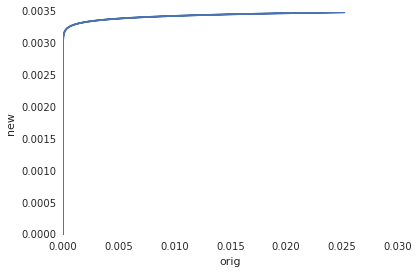

orig sum: 10.0
new sum: 10.0


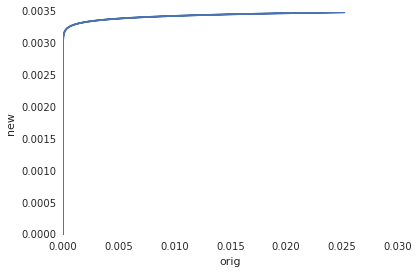

orig sum: 10.0
new sum: 10.0


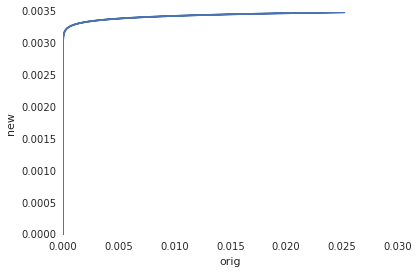

p1_hat: [ 0.249]
[ 1.9932983] -46.7830333694


In [274]:
N = 1000.0
x1 = 250.0
x2 = 750.0
_, x0hat, _ = calcLODs_multicoupled([[N/2]], [[30]], 1, N) # returns LOD, mu_MLE
_, x1hat, _ = calcLODs_multicoupled([[x1]], [[30]], 1, N) # returns LOD, mu_MLE
LOD, x2hat, LODnull = calcLODs_multicoupled([[x2]], [[30]], 1, N) # returns LOD, mu_MLE

if False:
    pylab.axvline(x0hat / N)
    pylab.axvline(x1hat / N)
    pylab.axvline(x2hat / N)
    pylab.axvline(x1 / N, ls=":")
    pylab.axvline(x2 / N, ls=":")
    pylab.axvline(0, ls="-", color="k", alpha=0.5)
    pylab.axvline(1, ls="-", color="k", alpha=0.5)
    seaborn.despine(offset=10)
    pylab.show()

print "p1_hat:", x1hat / N
print LOD, LODnull

p_hat: 0.2475000001


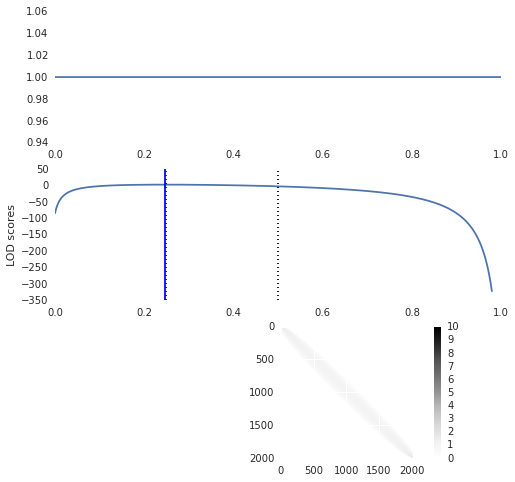

In [269]:
# let's make a matrix to do p(x|p) / p(x)
N = 100.0
x = numpy.arange(1e-10, 1+1e-10, 0.0005)
mat = numpy.zeros((len(x), len(x)))
p_x_given_y = scipy.stats.norm.pdf(N*x, 25, 1.5**0.5)
p_x = scipy.stats.norm.pdf(N*x, N/2, (0.5*0.5*N)**0.5) # replace this with beta-binomial stuff later (or just inflated gaussian?)
ab = 1.0
p_x = beta_binom_pdf(N*x, N, ab, ab)

for r, curr_x in enumerate(x):
    p_x_given_p = scipy.stats.norm.pdf(N*x, curr_x*N, (curr_x*(1.0-curr_x)*N)**0.5)
    mat[r, :] = p_x_given_p / p_x

pylab.gcf().set_size_inches(8,8)
pylab.subplot(311)
pylab.plot(x, scipy.stats.beta.pdf(x, ab, ab))

pylab.subplot(312)
lod = numpy.log10(numpy.dot(mat, p_x_given_y))
pylab.plot(x, lod)
pylab.axvline(0.5, color="k", ls=":")
pylab.axvline(x[lod.argmax()])
pylab.axvline(0.25, ls=":")
pylab.ylabel("LOD scores")
print "p_hat:", x[lod.argmax()]

pylab.subplot(313)
pylab.imshow(numpy.log10(mat), vmax=10, vmin=0, interpolation="nearest")
pylab.colorbar()
pylab.show()


In [40]:
data = pandas.DataFrame({"freq": [0.25, 0.23, 0.46], "v1":[1,0,0], "v2":[0,1,0], "v3":[0,0,1]})
data
# mod2 = smf.glm("freq ~ v1 + v2 + v3", data, family=sm.families.Binomial()).fit()
# mod2 = smf.glm("freq ~ 1", data, family=sm.families.Binomial()).fit()
mod2 = smf.GLM([[100,1000],[110,75]], [[1,0],[0,1]], family=sm.families.Binomial()).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ['y1', 'y2']   No. Observations:                    2
Model:                            GLM   Df Residuals:                        0
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -5.9939
Date:                Tue, 17 Mar 2015   Deviance:                  -2.2204e-14
Time:                        20:05:42   Pearson chi2:                 2.56e-30
No. Iterations:                     7                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -2.3026      0.105    -21.954      0.000        -2.508    -2.097
x2             0.3830      0.150      2.558      0.011         0.089     0.676
==============================================================================
"""

In [63]:
scipy.stats.binom_test([110,75])

0.012220636571467918

In [64]:
mod2 = smf.GLM([[50,500],[50,500],[110,75]], [[1,0],[1,0],[0,1]], family=sm.families.Binomial()).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ['y1', 'y2']   No. Observations:                    3
Model:                            GLM   Df Residuals:                        1
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -8.4771
Date:                Wed, 18 Mar 2015   Deviance:                   4.4409e-14
Time:                        01:45:02   Pearson chi2:                 2.56e-30
No. Iterations:                     7                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -2.3026      0.105    -21.954      0.000        -2.508    -2.097
x2             0.3830      0.150      2.558      0.011         0.089     0.676
==============================================================================
"""

In [65]:
# print(dir(mod2))
# print(mod2.pvalues)
# print(mod2.llf, mod2.llnull)
print("LLR:", 2.0 * (mod2.llf - mod2.llnull))

LLR: 224.430366085


In [50]:
import sys
sys.version

'2.7.6 (default, Mar 22 2014, 22:59:56) \n[GCC 4.8.2]'